In [1]:
#
# Project 2, starter code Part a
#

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
from tensorflow.keras import models
from skimage import color

In [2]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpus)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        devices = device_lib.list_local_devices()
        avail_gpu = [x for x in devices if x.device_type == 'GPU']
        print('\n',avail_gpu)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No gpus available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs

 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3048682292
locality {
  bus_id: 1
  links {
  }
}
incarnation: 792969280457807655
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
# Fixed, no need change
def load_data(file):
    file = 'data\\'+file
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    data = tf.reshape(data, [-1,3, 32, 32])
    data = tf.transpose(data,(0,2,3,1))
    labels = np.array(labels, dtype=np.int32)
    return data, labels

In [4]:
def load_history(path):
    path = 'histories\\'+path
    with open(path, 'rb') as fo:
        try:
            history = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            history = pickle.load(fo, encoding='latin1')
    return history

In [5]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

In [6]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):
    ''' Note: This model is incomplete. You need to add suitable layers.
    '''

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(32,32,3)))
    model.add(layers.Conv2D(num_ch_c1, 9, padding='valid', activation='relu', input_shape=(None, None, 3)))
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Conv2D(num_ch_c2, 5, padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(300, activation=None))
    model.add(layers.Dense(10, use_bias=True, activation='softmax', input_shape=(300,)))  # Here no softmax because we have combined it with the loss
    return model
#model = make_model(50,60,False)
#model.summary()

In [14]:
def save_model(num_ch_c1,num_ch_c2,optimizer_,history,use_dropout):
    # Create folder to store models and results
    if not os.path.exists('./models'):
        os.mkdir('./models')
    if not os.path.exists('./results'):
        os.mkdir('./results')

    # Save model
    if use_dropout:
        model.save(f'./models/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
        with open(f'histories/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    else:
        model.save(f'./models/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')
        with open(f'histories/{num_ch_c1}_{num_ch_c2}_{optimizer_}_nodropout', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

In [8]:
def create_opt(optimizer_,lr):
    if optimizer_ == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum = 0.1)
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    elif optimizer_ == 'Adam':  # Question 3(c)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')
    return optimizer

In [9]:
# Save the plot for losses
def plot_loss(loss,test_loss,use_dropout):
    train_loss = loss
    val_loss = test_loss
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.pdf')
    else:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.pdf'
        )
    plt.show()
    plt.close()

In [10]:
# Save the plot for accuracy
def plot_acc(acc,val_acc,use_dropout):
    train_acc = acc
    test_acc = val_acc
    plt.figure(figsize=(10,8))
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.pdf'
        )
    else:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.pdf'
        )
    plt.show()
    plt.close()

In [13]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

num_ch_c1 = 10  # Question 2
num_ch_c2 = 20  # Question 2

optimizer_list = ['SGD','SGD-momentum','RMSProp','Adam']

epochs = 500  # Fixed
batch_size = 128  # Fixed
learning_rate = 0.001
optimizer_ = 'SGD'  # Question 3
use_dropout = False  # Question 3(d) (see make_model)

x_train, y_train = load_data('data_batch_1')
x_test, y_test = load_data('test_batch_trim')

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#for optimizer_ in optimizer_list:
# Initialize optimizer
optimizer = create_opt(optimizer_,learning_rate)
# Initialize model
model = make_model(num_ch_c1, num_ch_c2, use_dropout)

# Training
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test))

save_model(num_ch_c1,num_ch_c2,optimizer_,history,use_dropout)

# Save the plot for losses
plot_loss(history.history['loss'],history.history['val_loss'],use_dropout)

# Save the plot for accuracies
plot_acc(history.history['accuracy'],history.history['val_accuracy'],use_dropout)

Epoch 1/500
79/79 [==============================] - 1s 8ms/step - loss: 2.3063 - accuracy: 0.0916 - val_loss: 2.3022 - val_accuracy: 0.0995
Epoch 2/500
79/79 [==============================] - 0s 6ms/step - loss: 2.3024 - accuracy: 0.0964 - val_loss: 2.2990 - val_accuracy: 0.1065
Epoch 3/500
79/79 [==============================] - 1s 7ms/step - loss: 2.2995 - accuracy: 0.1080 - val_loss: 2.2963 - val_accuracy: 0.1105
Epoch 4/500
79/79 [==============================] - 1s 6ms/step - loss: 2.2949 - accuracy: 0.1134 - val_loss: 2.2936 - val_accuracy: 0.1075
Epoch 5/500
79/79 [==============================] - 1s 6ms/step - loss: 2.2923 - accuracy: 0.1148 - val_loss: 2.2906 - val_accuracy: 0.1100
Epoch 6/500
79/79 [==============================] - 0s 6ms/step - loss: 2.2907 - accuracy: 0.1100 - val_loss: 2.2875 - val_accuracy: 0.1215
Epoch 7/500
79/79 [==============================] - 1s 6ms/step - loss: 2.2866 - accuracy: 0.1284 - val_loss: 2.2839 - val_accuracy: 0.1365
Epoch 8/500
7

Epoch 59/500
79/79 [==============================] - 1s 7ms/step - loss: 1.8849 - accuracy: 0.3242 - val_loss: 1.9071 - val_accuracy: 0.2960
Epoch 60/500
79/79 [==============================] - 1s 6ms/step - loss: 1.8971 - accuracy: 0.3167 - val_loss: 1.9020 - val_accuracy: 0.3085
Epoch 61/500
79/79 [==============================] - 0s 6ms/step - loss: 1.8786 - accuracy: 0.3342 - val_loss: 1.8974 - val_accuracy: 0.3110
Epoch 62/500
79/79 [==============================] - 1s 6ms/step - loss: 1.8660 - accuracy: 0.3392 - val_loss: 1.8966 - val_accuracy: 0.3095
Epoch 63/500
79/79 [==============================] - 0s 6ms/step - loss: 1.8813 - accuracy: 0.3380 - val_loss: 1.8995 - val_accuracy: 0.3045
Epoch 64/500
79/79 [==============================] - 1s 7ms/step - loss: 1.8770 - accuracy: 0.3302 - val_loss: 1.9060 - val_accuracy: 0.2985
Epoch 65/500
79/79 [==============================] - 1s 7ms/step - loss: 1.8761 - accuracy: 0.3298 - val_loss: 1.8829 - val_accuracy: 0.3125
Epoch 

79/79 [==============================] - 1s 6ms/step - loss: 1.7047 - accuracy: 0.3961 - val_loss: 1.7529 - val_accuracy: 0.3625
Epoch 117/500
79/79 [==============================] - 1s 7ms/step - loss: 1.7143 - accuracy: 0.3892 - val_loss: 1.7402 - val_accuracy: 0.3630
Epoch 118/500
79/79 [==============================] - 1s 6ms/step - loss: 1.7042 - accuracy: 0.3817 - val_loss: 1.7369 - val_accuracy: 0.3585
Epoch 119/500
79/79 [==============================] - 1s 6ms/step - loss: 1.7093 - accuracy: 0.3935 - val_loss: 1.7499 - val_accuracy: 0.3620
Epoch 120/500
79/79 [==============================] - 1s 6ms/step - loss: 1.7022 - accuracy: 0.3993 - val_loss: 1.7583 - val_accuracy: 0.3580
Epoch 121/500
79/79 [==============================] - 1s 7ms/step - loss: 1.7035 - accuracy: 0.3934 - val_loss: 1.7408 - val_accuracy: 0.3620
Epoch 122/500
79/79 [==============================] - 1s 7ms/step - loss: 1.6958 - accuracy: 0.3931 - val_loss: 1.7189 - val_accuracy: 0.3725
Epoch 123/500

79/79 [==============================] - 1s 6ms/step - loss: 1.6052 - accuracy: 0.4273 - val_loss: 1.6316 - val_accuracy: 0.4100
Epoch 174/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5852 - accuracy: 0.4281 - val_loss: 1.6811 - val_accuracy: 0.3880
Epoch 175/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5906 - accuracy: 0.4246 - val_loss: 1.6387 - val_accuracy: 0.4110
Epoch 176/500
79/79 [==============================] - 0s 6ms/step - loss: 1.5959 - accuracy: 0.4313 - val_loss: 1.6279 - val_accuracy: 0.4045
Epoch 177/500
79/79 [==============================] - 0s 6ms/step - loss: 1.5836 - accuracy: 0.4363 - val_loss: 1.6860 - val_accuracy: 0.3825
Epoch 178/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5573 - accuracy: 0.4353 - val_loss: 1.6700 - val_accuracy: 0.3930
Epoch 179/500
79/79 [==============================] - 1s 7ms/step - loss: 1.5819 - accuracy: 0.4383 - val_loss: 1.7162 - val_accuracy: 0.3905
Epoch 180/500

79/79 [==============================] - 1s 7ms/step - loss: 1.5311 - accuracy: 0.4536 - val_loss: 1.6907 - val_accuracy: 0.4150
Epoch 231/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5304 - accuracy: 0.4572 - val_loss: 1.6318 - val_accuracy: 0.4135
Epoch 232/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5046 - accuracy: 0.4680 - val_loss: 1.6645 - val_accuracy: 0.3975
Epoch 233/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5218 - accuracy: 0.4496 - val_loss: 1.6526 - val_accuracy: 0.4130
Epoch 234/500
79/79 [==============================] - 0s 6ms/step - loss: 1.5154 - accuracy: 0.4545 - val_loss: 1.6404 - val_accuracy: 0.4210
Epoch 235/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5160 - accuracy: 0.4519 - val_loss: 1.6757 - val_accuracy: 0.3970
Epoch 236/500
79/79 [==============================] - 1s 6ms/step - loss: 1.5119 - accuracy: 0.4590 - val_loss: 1.5649 - val_accuracy: 0.4385
Epoch 237/500

79/79 [==============================] - 1s 7ms/step - loss: 1.4757 - accuracy: 0.4624 - val_loss: 1.5879 - val_accuracy: 0.4310
Epoch 288/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4798 - accuracy: 0.4652 - val_loss: 1.5655 - val_accuracy: 0.4295
Epoch 289/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4731 - accuracy: 0.4760 - val_loss: 1.5467 - val_accuracy: 0.4415
Epoch 290/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4725 - accuracy: 0.4610 - val_loss: 1.5494 - val_accuracy: 0.4490
Epoch 291/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4868 - accuracy: 0.4588 - val_loss: 1.6319 - val_accuracy: 0.4205
Epoch 292/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4736 - accuracy: 0.4685 - val_loss: 1.5418 - val_accuracy: 0.4460
Epoch 293/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4760 - accuracy: 0.4707 - val_loss: 1.5896 - val_accuracy: 0.4445
Epoch 294/500

79/79 [==============================] - 1s 7ms/step - loss: 1.4237 - accuracy: 0.4894 - val_loss: 1.7312 - val_accuracy: 0.3925
Epoch 345/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4341 - accuracy: 0.4790 - val_loss: 1.5022 - val_accuracy: 0.4605
Epoch 346/500
79/79 [==============================] - 1s 6ms/step - loss: 1.4288 - accuracy: 0.4897 - val_loss: 1.5088 - val_accuracy: 0.4520
Epoch 347/500
79/79 [==============================] - 1s 6ms/step - loss: 1.4255 - accuracy: 0.4817 - val_loss: 1.5168 - val_accuracy: 0.4580
Epoch 348/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4149 - accuracy: 0.4907 - val_loss: 1.5952 - val_accuracy: 0.4380
Epoch 349/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4423 - accuracy: 0.4794 - val_loss: 1.6855 - val_accuracy: 0.4275
Epoch 350/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4161 - accuracy: 0.4887 - val_loss: 1.6063 - val_accuracy: 0.4425
Epoch 351/500

79/79 [==============================] - 1s 7ms/step - loss: 1.3928 - accuracy: 0.4998 - val_loss: 1.6252 - val_accuracy: 0.4260
Epoch 402/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4006 - accuracy: 0.4942 - val_loss: 1.4856 - val_accuracy: 0.4610
Epoch 403/500
79/79 [==============================] - 1s 6ms/step - loss: 1.4133 - accuracy: 0.4937 - val_loss: 1.4954 - val_accuracy: 0.4530
Epoch 404/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4125 - accuracy: 0.4861 - val_loss: 1.7462 - val_accuracy: 0.4190
Epoch 405/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4178 - accuracy: 0.4952 - val_loss: 1.4687 - val_accuracy: 0.4770
Epoch 406/500
79/79 [==============================] - 1s 7ms/step - loss: 1.3890 - accuracy: 0.5025 - val_loss: 1.4796 - val_accuracy: 0.4655
Epoch 407/500
79/79 [==============================] - 1s 7ms/step - loss: 1.4051 - accuracy: 0.4953 - val_loss: 1.4860 - val_accuracy: 0.4635
Epoch 408/500

79/79 [==============================] - 1s 7ms/step - loss: 1.3531 - accuracy: 0.5158 - val_loss: 1.4915 - val_accuracy: 0.4675
Epoch 459/500
79/79 [==============================] - 1s 7ms/step - loss: 1.3735 - accuracy: 0.5046 - val_loss: 1.4632 - val_accuracy: 0.4770
Epoch 460/500
79/79 [==============================] - 1s 7ms/step - loss: 1.3548 - accuracy: 0.5092 - val_loss: 1.5536 - val_accuracy: 0.4440
Epoch 461/500
79/79 [==============================] - 1s 7ms/step - loss: 1.3779 - accuracy: 0.5027 - val_loss: 1.6261 - val_accuracy: 0.4315
Epoch 462/500
79/79 [==============================] - 1s 7ms/step - loss: 1.3636 - accuracy: 0.5124 - val_loss: 1.5068 - val_accuracy: 0.4745
Epoch 463/500
79/79 [==============================] - 1s 7ms/step - loss: 1.3477 - accuracy: 0.5225 - val_loss: 1.4543 - val_accuracy: 0.4780
Epoch 464/500
79/79 [==============================] - 1s 7ms/step - loss: 1.3584 - accuracy: 0.5122 - val_loss: 1.4515 - val_accuracy: 0.4895
Epoch 465/500

C:\Users\Yuhan\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2342: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\Yuhan\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1395: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: ./models/QuestionA2_10_20_SGD_no_dropout\assets


OSError: [Errno 22] Invalid argument: 'histories/10_20_<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x0000025F36DA80A0>_nodropout'

In [11]:
if not os.path.exists('./histories'):
    os.mkdir('./histories')
with open('histories/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
save_model(num_ch_c1,num_ch_c2,optimizer_,history,use_dropout)

In [15]:
history1 = load_history('trainHistoryDict')

In [ ]:
# Display and save test images
if not os.path.exists('./figures'):
        os.mkdir('./figures')
image = x_test[0]
image2 = x_test[1]
for i in range(2):
    plt.title('test image '+str(i))
    plt.imshow(x_test[i])
    plt.savefig(
                f'./figures/test_image_{i+1}.png'
            )

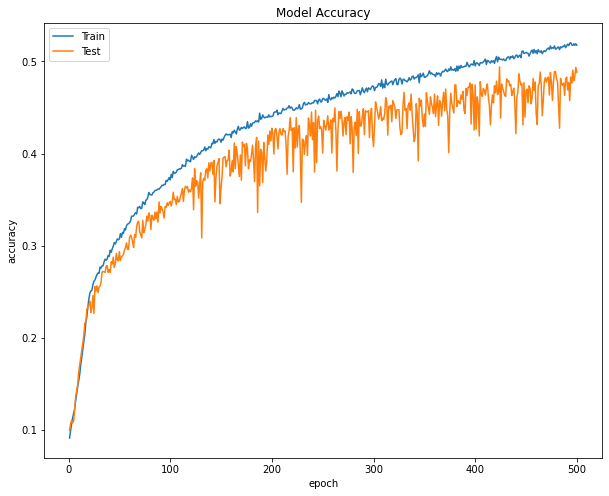

In [22]:
plot_acc(history1['accuracy'],history1['val_accuracy'],use_dropout)